# camera_calib_python

This is a python based camera calibration "library". Some things:

* Uses [nbdev](https://github.com/fastai/nbdev), which is an awesome and fun way to develop and tinker.
* Uses pytorch for optimization of intrinsic and extrinsic parameters. Each step in the model is modularized as its own pytorch `nn.module` in the `modules.ipynb` notebook. 
    * Optimization is carried out via the built in `LBFGS` optimizer. The `LBFGS` optimizer uses only the gradient to do a quasi second order optimization. However, I've noticed it's imperfect and can a take long time to converge in some cases.
    * The use of pytorch allows the forward pass to be easily modified. It also allows the use of any differentiable loss function although I've noticed that sum of squared errors seems to give the best results of the losses I've tried.
* The fiducial point detector for my calibration board uses a pytorch neural net under the hood (more info [here](https://github.com/justinblaber/fiducial_detect)), which is easily integrated into this library since its python based.

# Tutorial

In [1]:
import camera_calib.api as api

Before calibration can be done, we need the following information:

1. Images and their respective camera and pose indices
2. Calibration board geometry
3. Fiducial point detector
4. Control point refiner

### 1) Images

In [2]:
import re
from pathlib import Path

In [3]:
files_img = list(Path('data/dot_vision_checker').glob('*.png'))
files_img

[PosixPath('data/dot_vision_checker/SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2.png'),
 PosixPath('data/dot_vision_checker/SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1.png'),
 PosixPath('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:19-438636_CAM_3_FRAMEID_0_COUNTER_1.png'),
 PosixPath('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2.png'),
 PosixPath('data/dot_vision_checker/SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1.png')]

In [4]:
def _parse_name(name_img):
    match = re.match(r'''SERIAL_(?P<serial>.*)_
                         DATETIME_(?P<date>.*)_
                         CAM_(?P<cam>.*)_
                         FRAMEID_(?P<frameid>.*)_
                         COUNTER_(?P<counter>.*).png''', 
                     name_img, 
                     re.VERBOSE)
    return match.groupdict()

In [5]:
imgs = []
for file_img in files_img:
    dict_group = _parse_name(file_img.name)
    img = api.File16bitImg(file_img)
    img.idx_cam = int(dict_group['cam'])-1
    img.idx_cb  = int(dict_group['counter'])-1
    imgs.append(img)

In [6]:
for img in imgs: print(f'{img.name} - cam: {img.idx_cam} - cb: {img.idx_cb}')

SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2 - cam: 1 - cb: 1
SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1 - cam: 0 - cb: 0
SERIAL_16276942_DATETIME_2019-06-07-00:38:19-438636_CAM_3_FRAMEID_0_COUNTER_1 - cam: 2 - cb: 0
SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2 - cam: 2 - cb: 1
SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1 - cam: 1 - cb: 0


### 2) Calibration board geometry

The calibration board geometry specifies where fiducial markers and control points are located. For this example, my dot vision checker board is used.

In [7]:
h_cb = 50.8
w_cb = 50.8
h_f = 42.672
w_f = 42.672
num_c_h = 16
num_c_w = 16
spacing_c = 2.032
cb_geom = api.CbGeom(h_cb, w_cb,
                     api.CpCSRGrid(num_c_h, num_c_w, spacing_c),
                     api.FmCFPGrid(h_f, w_f))

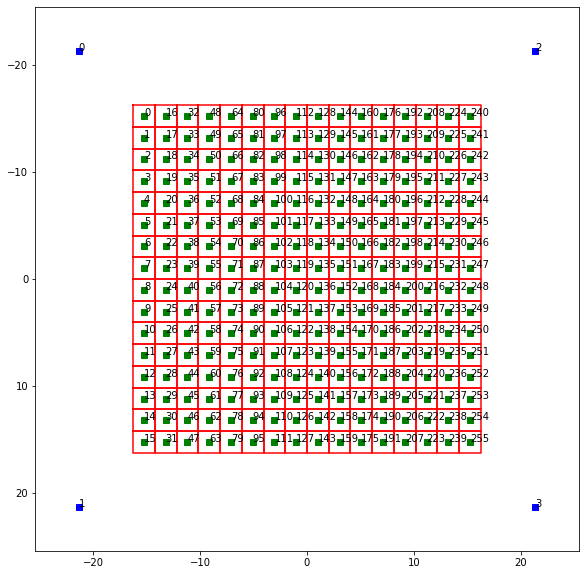

In [8]:
cb_geom.plot()

### 3) Fiducial detector

In [9]:
from pathlib import Path

This fiducial detector will take in an image and return the locations of the fiducial markers. The detector in this example is a neural net trained specifically on my calibration board. More info available at:

* https://github.com/justinblaber/fiducial_detect

In [10]:
file_model = Path('models/dot_vision_checker.pth')
detector = api.DotVisionCheckerDLDetector(file_model)

### 4) Control Point Refiner

The refiner will take in an image, initial guesses for control points, and the boundaries around the control points, and return a refined point. The boundaries help determine how much neighboring info can be used to refine the control point.

In [11]:
refiner = api.OpenCVCheckerRefiner(hw_min=5, hw_max=15, cutoff_it=20, cutoff_norm=1e-3)

## Calibrate

Now, we can calibrate

In [12]:
calib = api.multi_calib(imgs, cb_geom, detector, refiner)

Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1...
Refining single parameters...
 - Iteration: 000 - Norm:    0.00492 - Loss:    5.36733
 - Iteration: 001 - Norm:    0.14985 - Loss:    3.73449
 - Iteration: 002 - Norm:    0.01378 - Loss:    3.72178
 - Iteration: 003 - Norm:    3.80677 - Loss:    3.50140
 - Iteration: 004 - Norm:   60.91136 - Loss:    1.69839
 - Iteration: 005 - Norm:    0.00000 - Loss:    1.69839
Refining control points for: SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2...
Refining control points for: SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1...
Refining single parameters...
 - Iteration: 000 - Norm:    0.04150 - Loss:  145.18373
 - Iteration: 001 - Norm:    0.13431 - Loss:   83.63355
 - Iteration: 002 - Norm:    0.84358 - Loss:    3.92886
 - Iteration: 003 - Norm:    0.27788 - Loss:    3.59249
 - Iteration: 004 - Norm:   27.32694 - Loss:    2.

From Bo Li's calibration paper, we know the coordinate graph of calibration board poses and cameras forms a bipartite graph. For debugging purposes this is displayed below.

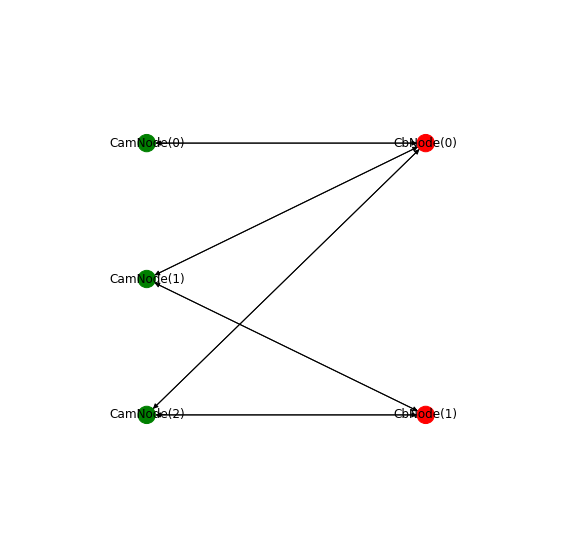

In [13]:
api.plot_bipartite(calib)

Plot residuals

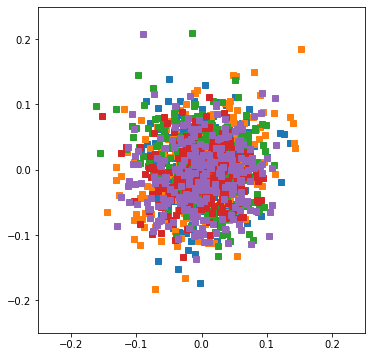

In [14]:
api.plot_residuals(calib);

Plot extrinsics; note that `%matplotlib notebook` can be used to make the plot interactive

In [15]:
import matplotlib.pyplot as plt

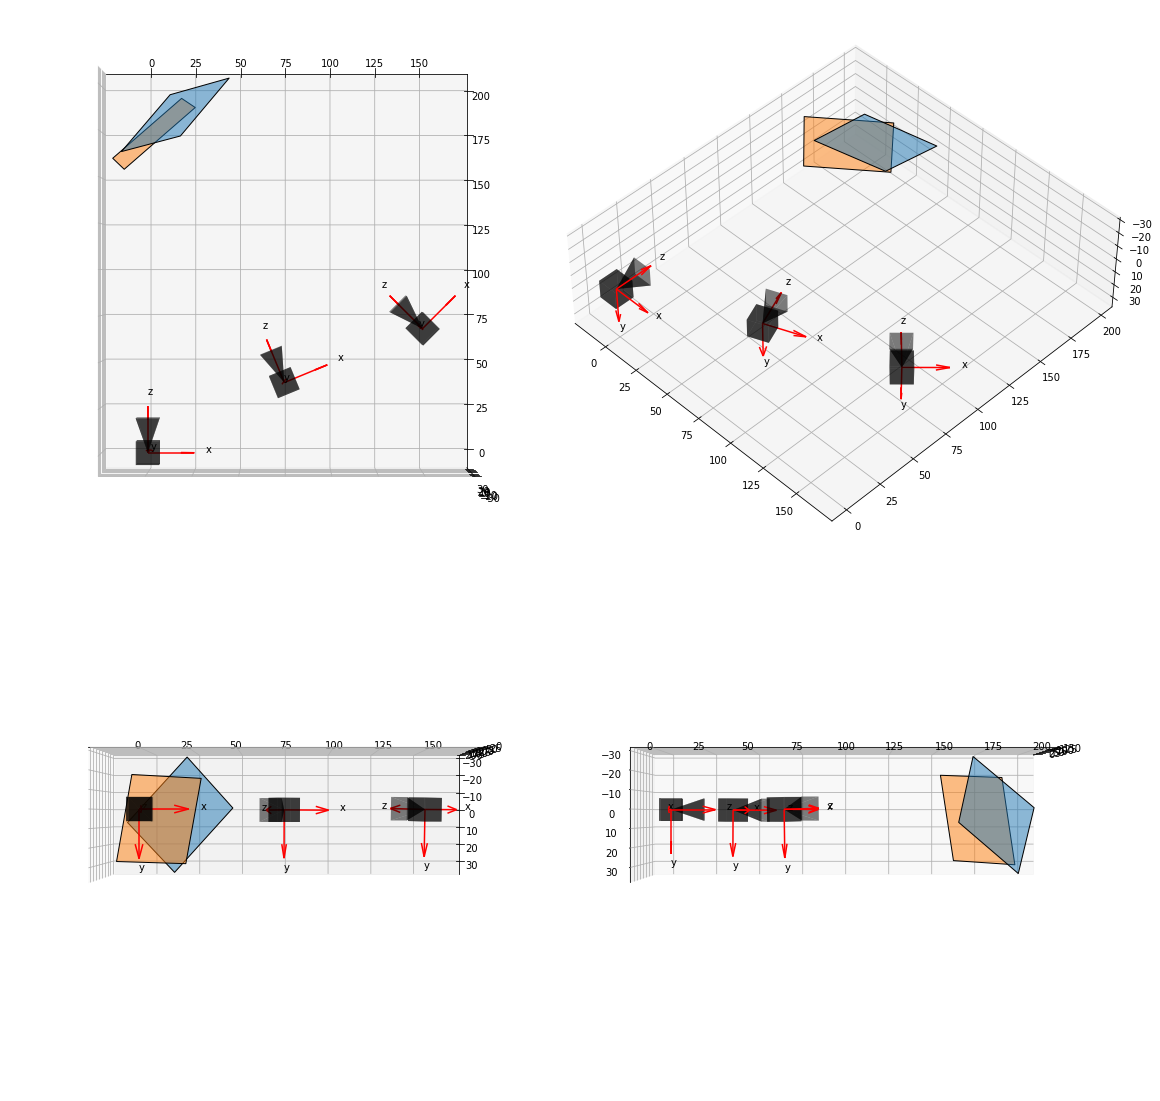

In [16]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(2, 2, 1, projection='3d')
api.plot_extrinsics(calib, ax=ax)
ax.view_init(elev=90, azim=-90)

ax = fig.add_subplot(2, 2, 2, projection='3d')
api.plot_extrinsics(calib, ax=ax)
ax.view_init(elev=45, azim=-45)

ax = fig.add_subplot(2, 2, 3, projection='3d')
api.plot_extrinsics(calib, ax=ax)
ax.view_init(elev=0, azim=-90)

ax = fig.add_subplot(2, 2, 4, projection='3d')
api.plot_extrinsics(calib, ax=ax)
ax.view_init(elev=0, azim=0)

plt.subplots_adjust(wspace=0, hspace=0)

This matches pretty closely to my camera rig

## Save/Load

Save

In [17]:
api.save(calib, '/tmp/calib.pth')

Load

In [18]:
del calib

In [19]:
calib = api.load('/tmp/calib.pth')

# Build

In [20]:
from camera_calib.utils import convert_notebook

In [21]:
convert_notebook()

<IPython.core.display.Javascript object>